# Machine Learning Classification

In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

#hyperopt
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt.pyll import scope
@scope.define
def intero(a):
     return int(a)


In [2]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)



In [3]:
dataset = pd.read_csv('Data after PP/Data')

In [4]:
dataset = dataset.drop(['Unnamed: 0'],axis=1)

In [5]:
dataset

,mu1,lam1,mu2,sigma,mu3,sigma3,w1,w2,w3,n_spikes,Target
0,0.099999,0.010000,1.376800e-01,0.069408,0.368091,0.172628,0.286221,4.179009e-01,2.958779e-01,1015.0,0.0
1,0.019293,0.019831,6.633874e-02,0.000100,0.100001,0.000520,1.000000,1.192093e-07,1.421085e-14,10364.0,0.0
2,0.043575,0.029764,1.779872e-01,0.000100,0.100064,0.000260,1.000000,1.192093e-07,1.421085e-14,4589.0,0.0
3,0.024164,0.022119,6.418069e-02,0.000100,0.100010,0.000718,1.000000,1.192093e-07,1.421085e-14,8274.0,0.0
4,0.048184,0.030814,4.696582e-03,0.000100,0.100139,0.000218,1.000000,1.192093e-07,1.421085e-14,4151.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
543,0.100000,0.011880,1.038845e-01,0.058294,0.483309,0.271518,0.332834,4.549999e-01,2.121657e-01,1029.0,1.0
544,0.018542,0.018771,1.807094e-01,0.000100,0.100000,0.000106,1.000000,1.192093e-07,1.421085e-14,10784.0,1.0
545,0.099969,0.039687,9.343772e-02,0.040354,0.267501,0.112234,0.630343,2.080073e-01,1.616492e-01,1523.0,1.0
546,0.056240,0.031443,1.643654e-07,0.000100,0.100001,0.000100,1.000000,1.192093e-07,1.421085e-14,3555.0,1.0


In [6]:
dataset['Target'].value_counts()

0.0    317
1.0    231
Name: Target, dtype: int64

## Train test split

In [7]:
X = dataset.drop(['Target'],axis=1)
y= dataset['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

## Standardization

In [8]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Comparison

In [9]:
cv = StratifiedKFold(4)

# PCA

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7,svd_solver='full')
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.fit(X_train).explained_variance_ratio_)

[0.53912977 0.14303272 0.13370652 0.08213452 0.0494511  0.02009942
 0.01457318]


## 1) Decision Tree Classifier

In [11]:
params = {'max_depth':np.linspace(2,10,dtype='int'),'criterion':['gini','entropy']}

clf = DecisionTreeClassifier(random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X_train,y_train)

gs_pca = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)
gs_pca = gs_pca.fit(X_train_pca,y_train)

In [12]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)
print('\n\n Result with PCA\n')
print("Best parameters set found :",gs_pca.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_pca.predict(X_test_pca)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)



Best parameters set found : {'criterion': 'entropy', 'max_depth': 4} 

Classification report on Test set

Accuracy:  0.912
Recall:  0.931
Precision:  0.871
ROC AUC:  0.915


 Result with PCA

Best parameters set found : {'criterion': 'entropy', 'max_depth': 3} 

Classification report on Test set

Accuracy:  0.832
Recall:  0.793
Precision:  0.807
ROC AUC:  0.827


## 2) Logistic Regression

In [13]:
params = {'C':np.logspace(-3,3,50),'penalty':['l1','l2','elasticnet']}

clf = LogisticRegression(solver='liblinear',random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X_train,y_train)

In [14]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)



Best parameters set found : {'C': 0.21209508879201905, 'penalty': 'l1'} 

Classification report on Test set

Accuracy:  0.825
Recall:  0.655
Precision:  0.905
ROC AUC:  0.802


## 3) Support Vector Machines

In [15]:
params = {'C':np.logspace(-3,3,50),'kernel':['linear','rbf']}

clf = SVC(random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X_train,y_train)

gs_pca = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_pca=gs_pca.fit(X_train_pca,y_train)

In [16]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)
print('\n\n Result with PCA\n')
print("Best parameters set found :",gs_pca.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_pca.predict(X_test_pca)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)



Best parameters set found : {'C': 8.286427728546842, 'kernel': 'rbf'} 

Classification report on Test set

Accuracy:  0.927
Recall:  0.931
Precision:  0.9
ROC AUC:  0.928


 Result with PCA

Best parameters set found : {'C': 19.306977288832496, 'kernel': 'rbf'} 

Classification report on Test set

Accuracy:  0.927
Recall:  0.948
Precision:  0.887
ROC AUC:  0.93


In [20]:
svm_params = gs.best_params_

## 4) Random Forest

In [17]:
params = {'n_estimators':np.linspace(10,150,dtype='int',num=10),'max_depth':np.linspace(2,5,dtype='int'),'criterion':['gini','entropy']}

clf = RandomForestClassifier(n_jobs=-1,random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)

gs=gs.fit(X_train,y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0624s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 388 ta

In [17]:
print("Best parameters set found :",gs.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

Best parameters set found : {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 134} 

Classification report on Test set

Accuracy:  0.912
Recall:  0.914
Precision:  0.883
ROC AUC:  0.913


## 5) Neural Net

In [18]:
X_train.shape

(411, 10)

In [18]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            20, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 7,421
Trainable params: 7,421
Non-trainable params: 0
______________________________________________________

In [19]:
metrics = [
    'accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)



history=model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=200,
    validation_data=(X_test, y_test),

)

Epoch 1/200
42/42 [==============================] - 1s 26ms/step - loss: 0.5562 - accuracy: 0.7299 - fn: 57.0000 - fp: 54.0000 - tn: 184.0000 - tp: 116.0000 - precision: 0.6824 - recall: 0.6705 - val_loss: 0.4021 - val_accuracy: 0.8467 - val_fn: 15.0000 - val_fp: 6.0000 - val_tn: 73.0000 - val_tp: 43.0000 - val_precision: 0.8776 - val_recall: 0.7414
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 0.3862 - accuracy: 0.8589 - fn: 31.0000 - fp: 27.0000 - tn: 211.0000 - tp: 142.0000 - precision: 0.8402 - recall: 0.8208 - val_loss: 0.2712 - val_accuracy: 0.8832 - val_fn: 9.0000 - val_fp: 7.0000 - val_tn: 72.0000 - val_tp: 49.0000 - val_precision: 0.8750 - val_recall: 0.8448
Epoch 3/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3770 - accuracy: 0.8321 - fn: 29.0000 - fp: 40.0000 - tn: 198.0000 - tp: 144.0000 - precision: 0.7826 - recall: 0.8324 - val_loss: 0.3417 - val_accuracy: 0.8613 - val_fn: 13.0000 - val_fp: 6.0000 - val_tn: 73.0000 - val_t

dict_keys(['loss', 'accuracy', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])


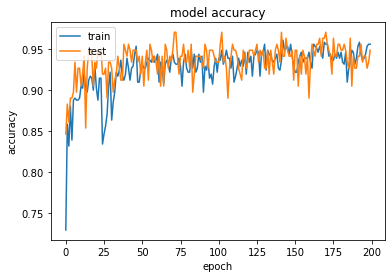

In [20]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [21]:
y_true, y_pred = y_test, model.predict_classes(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy:  0.949
Recall:  0.948
Precision:  0.932
ROC AUC:  0.949


## Feature importance

In [23]:
X.columns

Index(['mu1', 'lam1', 'mu2', 'sigma', 'mu3', 'sigma3', 'w1', 'w2', 'w3',
       'n_spikes'],
      dtype='object')

In [24]:
result = permutation_importance(svm_model, X_train, y_train, 
                           n_repeats=30,
                           random_state=0)

NameError: name 'svm_model' is not defined

In [25]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

NameError: name 'result' is not defined

# Classification with Nets after KA stimulation

In [22]:
from scipy import stats

In [23]:
dataset_after = pd.read_csv('Data after PP/DataAfter')

In [24]:
dataset_after = dataset_after.drop(['Unnamed: 0'],axis=1)

In [25]:
print('Target LRRK2 vs Healthy\n',dataset_after['Target'].value_counts())
print('Stimulated LRRK2 vs Healthy\n',dataset_after['Stimulation'].value_counts())

Target LRRK2 vs Healthy
 0.0    176
1.0    166
Name: Target, dtype: int64
Stimulated LRRK2 vs Healthy
 1.0    177
0.0    165
Name: Stimulation, dtype: int64


In [161]:
def plot_boxplot(target,column,dataset,dataset_after):
    x_list_param_boxplot=[]
    y_list_param_boxplot=[]


    y_list_param_boxplot.extend(dataset[dataset['Target']==target][column].values)
    len1 = dataset[dataset['Target']==target][column].values.shape[0]
    y_list_param_boxplot.extend(dataset_after[(dataset_after['Target']==target) &(dataset_after['Stimulation']==0)][column].values)
    len2 = dataset_after[(dataset_after['Target']==target) &(dataset_after['Stimulation']==0)][column].values.shape[0]
    y_list_param_boxplot.extend(dataset_after[(dataset_after['Target']==target) &(dataset_after['Stimulation']==1)][column].values)
    len3 = dataset_after[(dataset_after['Target']==target) &(dataset_after['Stimulation']==1)][column].values.shape[0]

    strs1 = ["Baseline" for x in range(len1)]
    strs2 = ["Control" for x in range(len2)]
    strs3 = ["Stimulated" for x in range(len3)]

    x_list_param_boxplot.extend(strs1)
    x_list_param_boxplot.extend(strs2)
    x_list_param_boxplot.extend(strs3)
    
    plt.figure(figsize=(5,5))
    
    if target==0:
        title = 'Healthy - '+column
    else:
        title = 'LRRK2 - '+column
    plt.title(title)
    sns.boxplot(x_list_param_boxplot,y_list_param_boxplot)
    
    #return y_list_param_boxplot
    stat,p_original=stats.shapiro(y_list_param_boxplot[:len1])
    stat,p=stats.shapiro(y_list_param_boxplot[len1:len1+len2])
    if (p>0.05) and (p_original>0.05):
        stat,t =stats.mannwhitneyu(y_list_param_boxplot[:len1],y_list_param_boxplot[len1:len1+len2],alternative='two-sided')
        print('Control: ',t)
    else:
        stat,t =stats.ttest_ind(y_list_param_boxplot[:len1],y_list_param_boxplot[len1:len1+len2])
        print('Control: ',t)
        
    stat,p=stats.shapiro(y_list_param_boxplot[len1+len2:])
    if (p>0.05) and (p_original>0.05):
        stat,t =stats.mannwhitneyu(y_list_param_boxplot[:len1],y_list_param_boxplot[len1+len2:],alternative='two-sided')
        print('Stimulation: ',t)
    else:
        stat,t =stats.ttest_ind(y_list_param_boxplot[:len1],y_list_param_boxplot[len1+len2:])
        print('Stimulation: ',t)
    
    

mu1
Healthy
Control:  0.0033996867836613566
Stimulation:  0.02082922589477501
LRRK2
Control:  0.4937893486786544
Stimulation:  8.793783190091203e-05



lam1
Healthy
Control:  0.005913487964413531
Stimulation:  0.17824482367731684
LRRK2
Control:  0.9212421685898304
Stimulation:  6.570341774232882e-06



mu2
Healthy
Control:  0.0037174448055440974
Stimulation:  0.09829923655899435
LRRK2
Control:  0.17523658903012715
Stimulation:  0.29207628422747817



sigma
Healthy
Control:  0.48332153887270424
Stimulation:  0.06032951474395615
LRRK2
Control:  0.6189784559724119
Stimulation:  0.03139484685495524



mu3
Healthy
Control:  0.10031378990101998
Stimulation:  0.04440028475895933
LRRK2
Control:  0.24592105820676097
Stimulation:  3.198823998328054e-06



sigma3
Healthy
Control:  0.14071142685502847
Stimulation:  0.2704032340489211
LRRK2
Control:  0.846893240538684
Stimulation:  2.7393039174885673e-05



w1
Healthy
Control:  0.554023305698465
Stimulation:  0.015817644418683427
LRRK2
Control:  0.

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Input data for shapiro has range zero. The results may not be accurate.


ValueError: All numbers are identical in mannwhitneyu

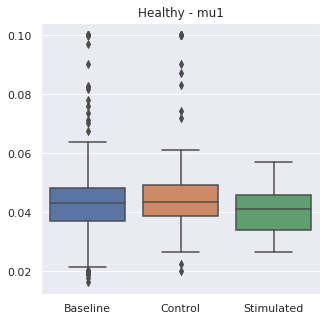

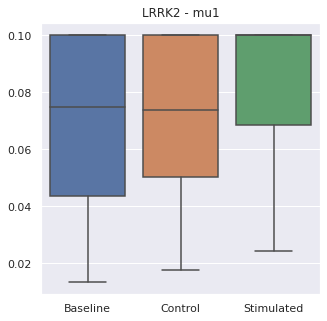

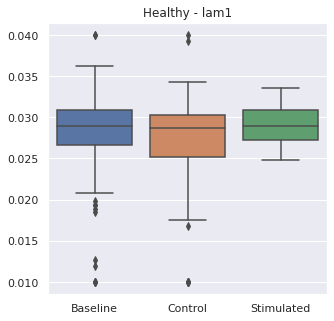

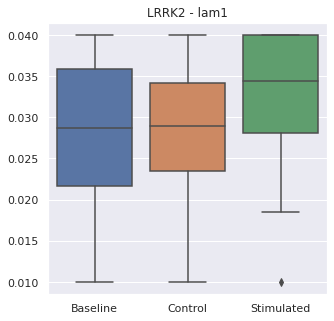

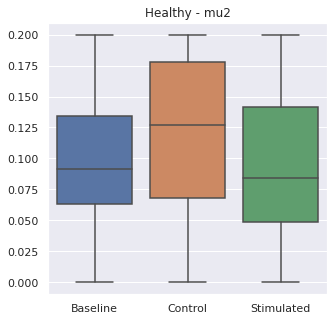

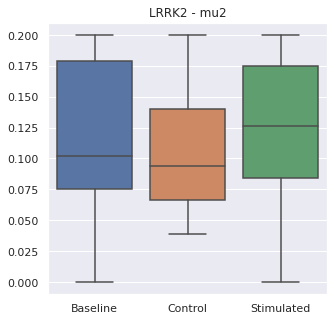

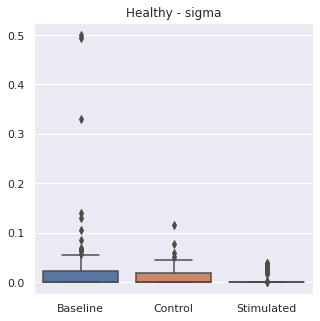

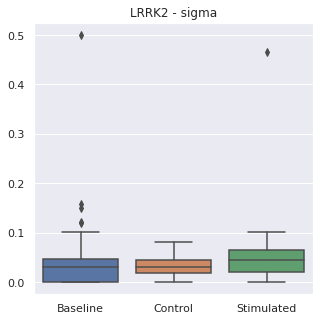

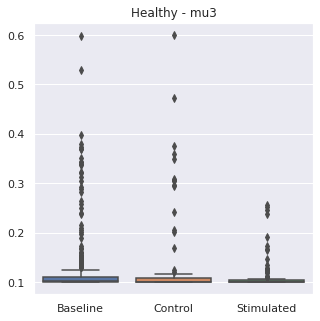

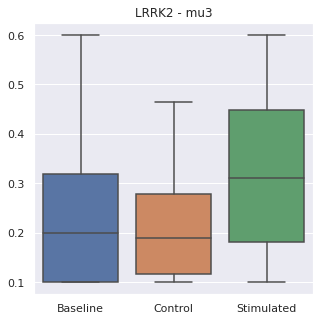

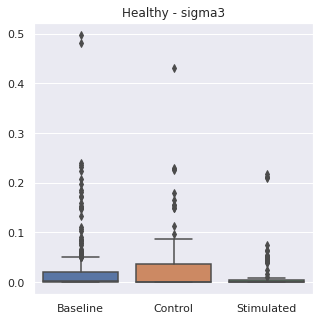

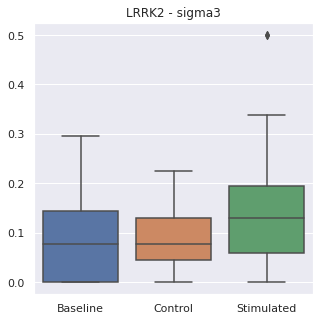

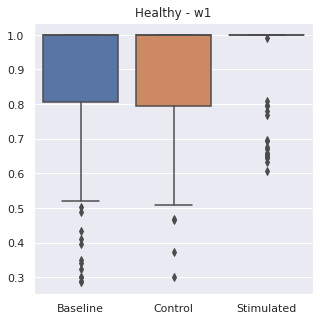

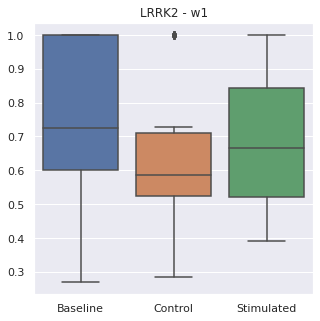

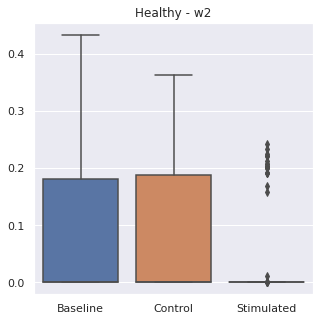

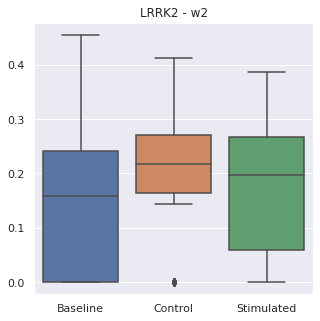

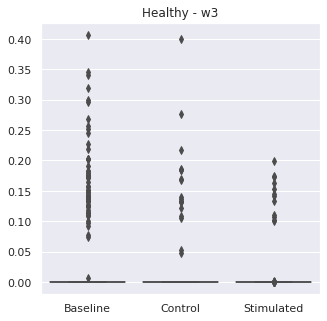

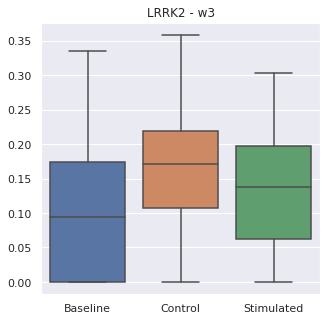

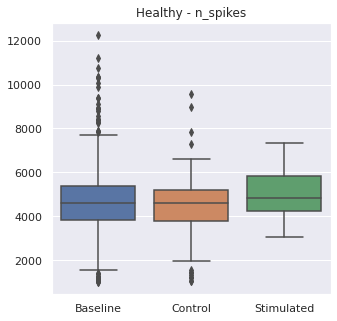

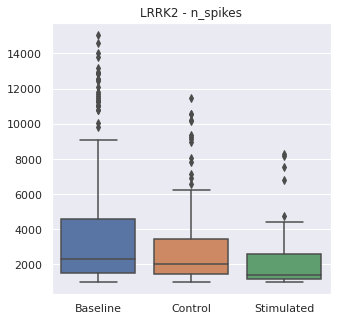

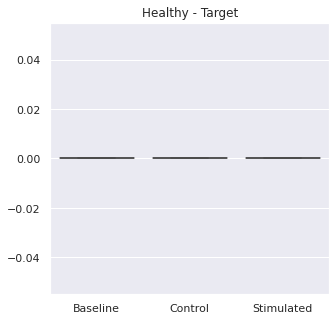

In [162]:
for col in dataset_after.columns.tolist():
    print(col)
    print('Healthy')
    t = plot_boxplot(0,col,dataset,dataset_after)
    print('LRRK2')
    t = plot_boxplot(1,col,dataset,dataset_after)
    print('\n\n')

# Unsupervised learning

In [163]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics

In [164]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [165]:
X = dataset_after.drop(['Target','Stimulation'],axis=1)

target = dataset_after['Target']
stim = dataset_after['Stimulation']

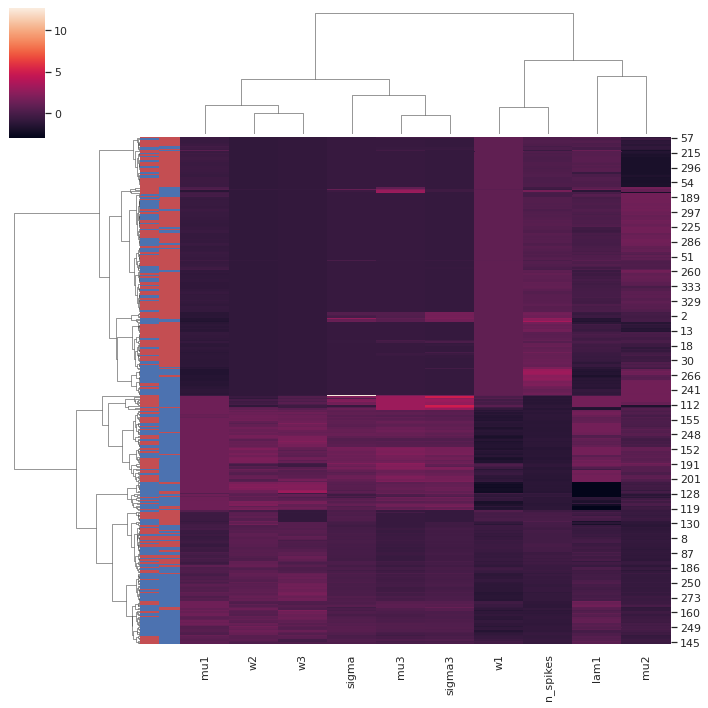

In [166]:
col = X.columns.tolist()
X = StandardScaler().fit_transform(X)


lut = dict(zip(stim.unique(), "rbg"))
row_colors_stim = stim.map(lut)
lut = dict(zip(target.unique(), "rbg"))
row_colors_target = target.map(lut)

row_colors=[row_colors_stim,row_colors_target]
X = pd.DataFrame(X,columns=col)
g = sns.clustermap(X,row_colors=row_colors,
                  method = 'ward',
                  metric='euclidean')

# Multilabel classification

In [26]:
dataset_after = pd.read_csv('Data after PP/DataAfter')
dataset_after = dataset_after.drop(['Unnamed: 0'],axis=1)

In [27]:
list_ml=[]
for i in dataset_after.index:
    if dataset_after.loc[i]['Target']==0 and dataset_after.loc[i]['Stimulation']==0:
        list_ml.append(0)
    elif dataset_after.loc[i]['Target']==1 and dataset_after.loc[i]['Stimulation']==0:
        list_ml.append(1)
    elif dataset_after.loc[i]['Target']==0 and dataset_after.loc[i]['Stimulation']==1:
        list_ml.append(2)
    else :
        list_ml.append(3)
        
        
## 0 ---> Healthy non stimulated
## 1 ---> LRRK2 non stimulated
## 2 ---> Healthy stimulated
## 3 ---> LRRK2 stimulated

In [28]:
dataset_after['MultiLabel Target']=list_ml

In [29]:
dataset_after['MultiLabel Target'].value_counts()

2    100
1     89
3     77
0     76
Name: MultiLabel Target, dtype: int64

In [171]:
X = dataset_after.drop(['Target','Stimulation','MultiLabel Target'],axis=1)
y= dataset_after['MultiLabel Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

## Standardization

In [172]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Comparison

In [173]:
cv = StratifiedKFold(4)

## 1) Decision Tree Classifier

In [174]:
print("Classification report on Test set\n")
gs = DecisionTreeClassifier(max_depth=7,random_state=12)
gs.fit(X_train,y_train)
y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred,average = 'weighted'),3)
precision = round(precision_score(y_true, y_pred,average = 'weighted'),3)
#roc_auc = round(roc_auc_score(y_true, y_pred,multi_class = 'ovr'),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)



Classification report on Test set

Accuracy:  0.57
Recall:  0.57
Precision:  0.569


Text(66.5, 0.5, 'True')

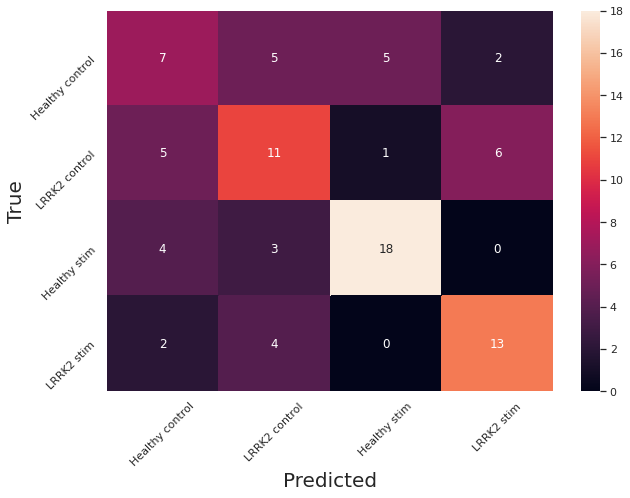

In [175]:
#print('ROC AUC: ',roc_auc)
cm=metrics.confusion_matrix(y_true,y_pred,labels=[0,1,2,3])
df_cm = pd.DataFrame(cm,columns=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'],index=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.) # for label size
chart = sns.heatmap(df_cm,annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_yticklabels(chart.get_yticklabels(), rotation=45)
plt.xlabel('Predicted',fontdict={'size':20})
plt.ylabel('True',fontdict={'size':20})

## 2) Logistic Regression

Classification report on Test set

Accuracy:  0.57
Recall:  0.57
Precision:  0.562


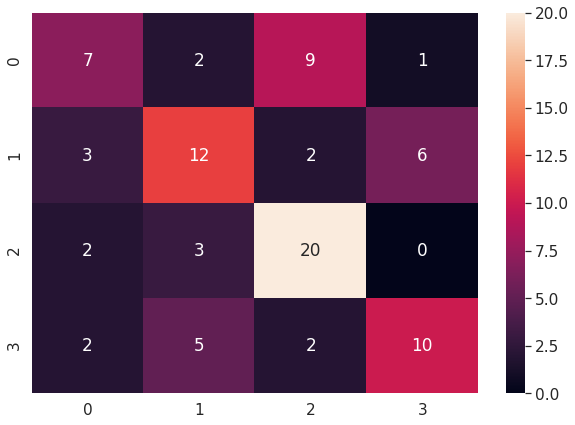

In [176]:
print("Classification report on Test set\n")
gs = LogisticRegression(penalty='l2',C=0.5,random_state=12)
gs.fit(X_train,y_train)
y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred,average = 'weighted'),3)
precision = round(precision_score(y_true, y_pred,average = 'weighted'),3)
#roc_auc = round(roc_auc_score(y_true, y_pred,multi_class = 'ovr'),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
#print('ROC AUC: ',roc_auc)
cm=metrics.confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm,annot=True)





## 3) Support Vector Machines

In [21]:
from hyperopt import hp

space = {}



#SVC
space['C']=hp.uniform('C',0.01,100)
space['kernel']=hp.choice('kernel',['rbf'])
space['gamma']=hp.choice('gamma',['scale','auto'])



In [22]:
from sklearn.model_selection import cross_val_score
def objective(params):
        ######################## hyper params ##############################

        params_SVC = {}

        params_SVC['C'] = params['C']
        params_SVC['kernel'] = params['kernel']
        params_SVC['gamma'] = params['gamma']
        

        ########################## Classifier definition ###################

        classifier = SVC(class_weight='balanced',random_state=12)
        classifier.set_params(**params_SVC)

        
        ######################### Model testing ################################

        shuffle = StratifiedKFold(n_splits=4, shuffle=True, random_state=12)
        
        

        score = cross_val_score(classifier, X_train, y_train, cv=shuffle, scoring='accuracy', n_jobs=-1)
        score = np.mean(score)
        
        

        return 1 - score

    ######################## Start optim ####################################



# The Trials object will store details of each iteration
trials = Trials()

    # Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=1000,
                trials=trials)

100%|██████████| 1000/1000 [00:14<00:00, 70.55trial/s, best loss: 0.08523700742432894]


In [23]:
cat = {}
cat['kernel'] = ['rbf']
cat['gamma'] = ['scale','auto']

        
best_models = performance_visualizer(trials, 100, choice=True, **cat)


In [24]:
best_models

,C,gamma,kernel,performance
113,9.476399,scale,rbf,0.914739
221,14.511044,auto,rbf,0.914739
936,6.640638,auto,rbf,0.914739
452,7.452752,scale,rbf,0.914739
925,7.277742,scale,rbf,0.914739
...,...,...,...,...
871,6.704111,auto,rbf,0.914739
626,9.082789,scale,rbf,0.914739
81,6.717309,auto,rbf,0.914739
748,7.615527,scale,rbf,0.914739


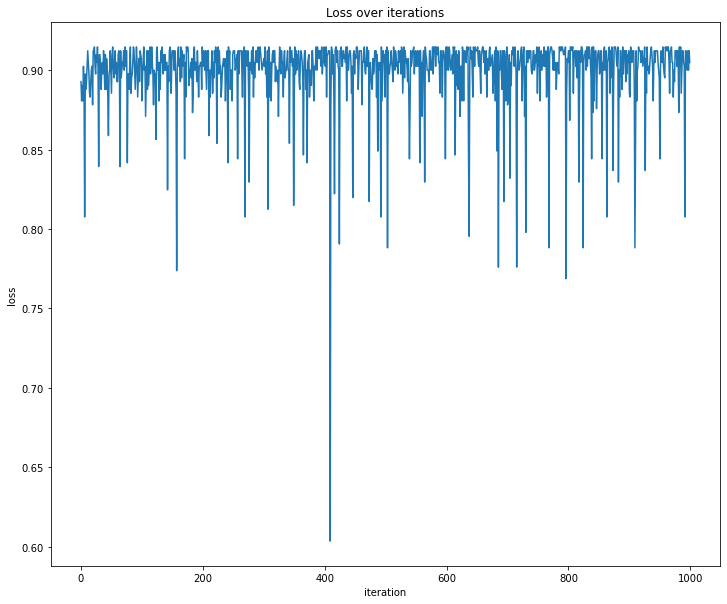

In [25]:
plt.figure(figsize=(12, 10))
sns.lineplot(data=1-pd.Series(data=trials.losses()))
plt.xlabel('iteration');
plt.ylabel('loss');
plt.title('Loss over iterations')
plt.show()

In [26]:
best_dict = best_models.to_dict(orient='records')[-1]

In [27]:
best_dict.pop('performance')

0.9147629925756711

In [28]:
best_dict

{'C': 5.546873527674233, 'gamma': 'scale', 'kernel': 'rbf'}

Classification report on Test set

Accuracy:  0.927
Recall:  0.931
Precision:  0.9
ROC AUC:  0.928


Text(66.5, 0.5, 'True')

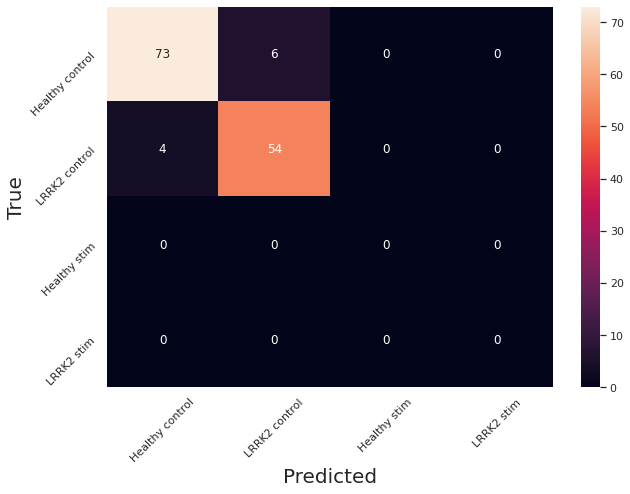

In [29]:
from sklearn import metrics

print("Classification report on Test set\n")
gs = SVC(probability=True,random_state=12)
gs.set_params(**best_dict)
gs.fit(X_train,y_train)
y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)
cm=metrics.confusion_matrix(y_true,y_pred,labels=[0,1,2,3])
df_cm = pd.DataFrame(cm,columns=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'],index=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.) # for label size
chart = sns.heatmap(df_cm,annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_yticklabels(chart.get_yticklabels(), rotation=45)
plt.xlabel('Predicted',fontdict={'size':20})
plt.ylabel('True',fontdict={'size':20})


## 4) K Nearest Neighbours

In [30]:
from hyperopt import hp

space = {}



#K Neighbours
space['n_neighbors']=hp.uniform('n_neighbors',2,100)
space['weights']=hp.choice('weights',['uniform','distance'])
space['algorithm']=hp.choice('algorithm',['auto','ball_tree','kd_tree','brute'])
space['p']=hp.choice('p',[1,2,3])



In [31]:
from sklearn.neighbors import KNeighborsClassifier

def objective(params):
        ######################## hyper params ##############################

        params_KN = {}

        params_KN['n_neighbors'] = int(params['n_neighbors'])
        params_KN['weights'] = params['weights']
        params_KN['algorithm'] = params['algorithm']
        params_KN['p'] = params['p']
        

        ########################## Classifier definition ###################

        classifier = KNeighborsClassifier(n_jobs=-1)
        classifier.set_params(**params_KN)

        
        ######################### Model testing ################################

        shuffle = StratifiedKFold(n_splits=4, shuffle=True, random_state=12)
        
        

        score = cross_val_score(classifier, X_train, y_train, cv=shuffle, scoring='accuracy', n_jobs=-1)
        score = np.mean(score)
        
        

        return 1 - score

    ######################## Start optim ####################################



# The Trials object will store details of each iteration
trials = Trials()

    # Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

100%|██████████| 100/100 [00:02<00:00, 44.22trial/s, best loss: 0.11195983247667995]


In [32]:
cat = {}
cat['weights'] = ['uniform','distance']
cat['algorithm'] = ['auto','ball_tree','kd_tree','brute']
cat['p'] = [1,2,3]
        
best_models = performance_visualizer(trials, 100, choice=True, **cat)


In [33]:
best_models.to_dict(orient='records')[-1]

{'algorithm': 'brute',
 'n_neighbors': 2.9641675675329813,
 'p': 3,
 'weights': 'distance',
 'performance': 0.88804016752332}

In [34]:
best_dict = best_models.to_dict(orient='records')[-1]

In [35]:
best_dict.pop('performance')

0.88804016752332

In [36]:
best_dict['n_neighbors']=int(best_dict['n_neighbors'])

Classification report on Test set

Accuracy:  0.934
Recall:  0.934
Precision:  0.935


Text(66.5, 0.5, 'True Label')

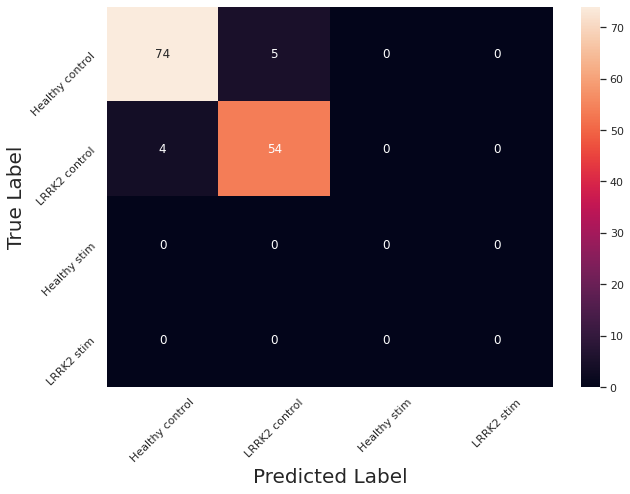

In [37]:
print("Classification report on Test set\n")
gs = KNeighborsClassifier()
gs.set_params(**best_dict)
gs.fit(X_train,y_train)
y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred,average = 'weighted'),3)
precision = round(precision_score(y_true, y_pred,average = 'weighted'),3)
#roc_auc = round(roc_auc_score(y_true, y_pred,multi_class = 'ovr'),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
#print('ROC AUC: ',roc_auc)
cm=metrics.confusion_matrix(y_true,y_pred,labels=[0,1,2,3])
df_cm = pd.DataFrame(cm,columns=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'],index=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.) # for label size
chart = sns.heatmap(df_cm,annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_yticklabels(chart.get_yticklabels(), rotation=45)
plt.xlabel('Predicted Label',fontdict={'size':20})
plt.ylabel('True Label',fontdict={'size':20})


## 5) Random Forest

In [41]:
from hyperopt import hp

space = {}


#RF
space['n_estimators'] = hp.choice('n_estimators', np.arange(50, 300,1, dtype=int))
space['max_samples'] = hp.uniform('max_samples',0.4,1)
space['max_samples'] = hp.uniform('max_samples',0.4,1)
space['max_features'] = hp.uniform('max_features',0.4,1)
space['criterion'] = hp.choice('criterion',['gini','entropy'])
space['max_depth'] = scope.intero(hp.quniform('max_depth',3,10,1))
space['ccp_alpha']=hp.uniform('ccp_alpha',0,0.001)
space['bootstrap']=hp.choice('bootstrap',[False,True])
space['min_samples_leaf']=scope.intero(hp.quniform('min_samples_leaf',1,5,1))
space['min_samples_split']=scope.intero(hp.quniform('min_samples_split',2,10,1))



In [67]:
from sklearn.ensemble import RandomForestClassifier

def objective(params):
        ######################## hyper params ##############################

        params_RF = {}
        
        params_RF['n_estimators'] = params['n_estimators']
        params_RF['max_samples'] = params['max_samples']
        params_RF['max_features'] = params['max_features']
        params_RF['criterion'] = params['criterion']
        params_RF['max_depth'] = params['max_depth']
        params_RF['ccp_alpha'] = params['ccp_alpha']
        params_RF['bootstrap'] = params['bootstrap']
        params_RF['min_samples_leaf'] = params['min_samples_leaf']
        params_RF['min_samples_split'] = params['min_samples_split']
        

        ########################## Classifier definition ###################

        classifier = RandomForestClassifier(n_jobs=-1)
        classifier.set_params(**params_RF)

        
        ######################### Model testing ################################

        shuffle = StratifiedKFold(n_splits=4, shuffle=True, random_state=12)
        
        

        score = cross_val_score(classifier, X_train, y_train, cv=shuffle, scoring='accuracy', n_jobs=-1)
        score = np.mean(score)
        
        

        return 1 - score

    ######################## Start optim ####################################



# The Trials object will store details of each iteration
trials = Trials()

    # Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
                space,
                algo=tpe.suggest,
                max_evals=500,
                trials=trials)

100%|██████████| 500/500 [02:51<00:00,  2.92trial/s, best loss: 0.08766419189034835]


In [68]:
cat = {}
cat['n_estimators'] = np.arange(50, 150, dtype=int)
cat['bootstrap'] = [False,True]
cat['criterion'] = ['gini','entropy']
best_models = performance_visualizer(trials, 300, choice=True, **cat)


In [69]:
pd.Series(data=trials.losses()).shape[0]

500

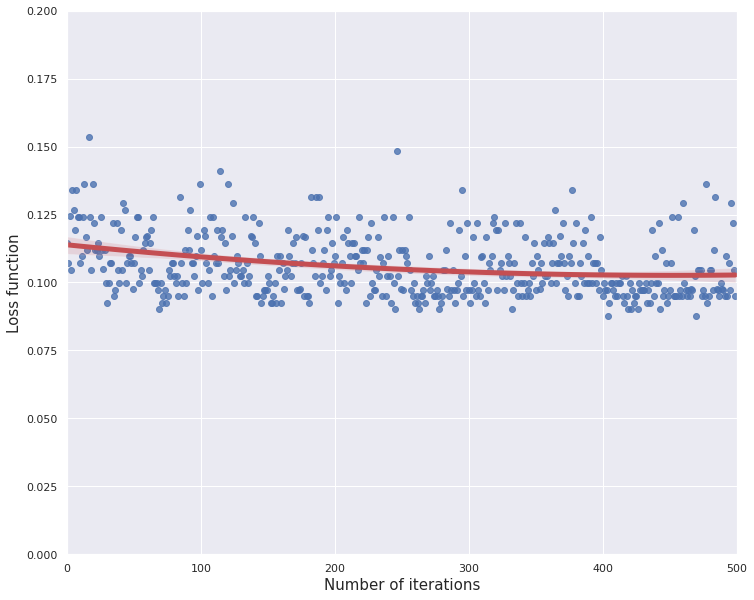

In [80]:
import matplotlib
plt.figure(figsize=(12, 10))
sns.regplot(x = np.arange(pd.Series(data=trials.losses()).shape[0]),y=pd.Series(data=trials.losses()),
            order = 2,line_kws={'lw':5,'color':'r'})
font = {'size'   : 30}

matplotlib.rc('font', **font)
plt.xlabel('Number of iterations',fontdict={'size':15});
plt.ylabel('Loss function',fontdict={'size':15});

plt.axis([0,500,0,0.2])
plt.show()

In [40]:
best_models

,bootstrap,ccp_alpha,criterion,max_depth,max_features,max_samples,min_samples_leaf,min_samples_split,n_estimators,performance
43,True,0.003114,entropy,1.0,0.673662,0.658783,2.0,8.0,197,0.785813
3,False,0.008215,gini,1.0,0.479988,0.532990,2.0,6.0,120,0.790643
61,True,0.007121,entropy,1.0,0.625872,0.721781,2.0,3.0,156,0.790667
226,True,0.007648,entropy,1.0,0.952663,0.883533,4.0,2.0,122,0.790667
142,True,0.007566,entropy,1.0,0.797834,0.851438,1.0,4.0,100,0.793094
...,...,...,...,...,...,...,...,...,...,...
174,True,0.007126,entropy,8.0,0.818324,0.882974,1.0,3.0,102,0.909885
246,True,0.007035,entropy,7.0,0.791144,0.971007,1.0,6.0,119,0.909909
37,True,0.006967,entropy,7.0,0.951589,0.892075,2.0,3.0,197,0.912312
262,True,0.007177,entropy,7.0,0.743513,0.921909,1.0,5.0,178,0.912312


In [36]:
best_models.to_dict(orient='records')[:-1]

[{'bootstrap': True,
  'ccp_alpha': 0.003234781189776231,
  'criterion': 'entropy',
  'max_depth': 7.0,
  'max_features': 0.8778359576628698,
  'max_samples': 0.6969701678352563,
  'min_samples_leaf': 1.0,
  'min_samples_split': 6.0,
  'n_estimators': 241,
  'performance': 0.8977251094612603},
 {'bootstrap': True,
  'ccp_alpha': 0.007252777130362391,
  'criterion': 'entropy',
  'max_depth': 5.0,
  'max_features': 0.7451143152356896,
  'max_samples': 0.9807538183733081,
  'min_samples_leaf': 1.0,
  'min_samples_split': 7.0,
  'n_estimators': 223,
  'performance': 0.8977251094612603},
 {'bootstrap': True,
  'ccp_alpha': 0.00790816281014876,
  'criterion': 'entropy',
  'max_depth': 8.0,
  'max_features': 0.7810337189795457,
  'max_samples': 0.6779871431641532,
  'min_samples_leaf': 2.0,
  'min_samples_split': 3.0,
  'n_estimators': 200,
  'performance': 0.8977251094612603},
 {'bootstrap': True,
  'ccp_alpha': 0.007173025510642941,
  'criterion': 'entropy',
  'max_depth': 9.0,
  'max_featu

In [255]:
best_dict = best_models.to_dict(orient='records')[-1]

In [256]:
best_dict.pop('performance')

0.62109375

In [257]:
best_dict['min_samples_leaf']=int(best_dict['min_samples_leaf'])
best_dict['min_samples_split']=int(best_dict['min_samples_split'])

Classification report on Test set

Accuracy:  0.709
Recall:  0.709
Precision:  0.725


Text(66.5, 0.5, 'True Label')

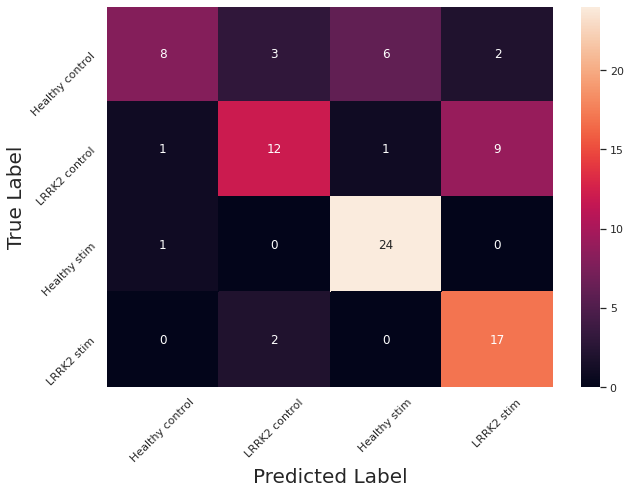

In [258]:
print("Classification report on Test set\n")
gs = RandomForestClassifier()
gs.set_params(**best_dict)
gs.fit(X_train,y_train)
y_true, y_pred = y_test, gs.predict(X_test)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred,average = 'weighted'),3)
precision = round(precision_score(y_true, y_pred,average = 'weighted'),3)
#roc_auc = round(roc_auc_score(y_true, y_pred,multi_class = 'ovr'),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
#print('ROC AUC: ',roc_auc)
cm=metrics.confusion_matrix(y_true,y_pred,labels=[0,1,2,3])
df_cm = pd.DataFrame(cm,columns=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'],index=['Healthy control','LRRK2 control','Healthy stim','LRRK2 stim'])
plt.figure(figsize = (10,7))
sns.set(font_scale=1.) # for label size
chart = sns.heatmap(df_cm,annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_yticklabels(chart.get_yticklabels(), rotation=45)
plt.xlabel('Predicted Label',fontdict={'size':20})
plt.ylabel('True Label',fontdict={'size':20})


# Binary classification model on new test set

In [4]:
dataset_after = pd.read_csv('Data after PP/DataAfter')
dataset_after = dataset_after.drop(['Unnamed: 0'],axis=1)

In [5]:
list_ml=[]
for i in dataset_after.index:
    if dataset_after.loc[i]['Target']==0 and dataset_after.loc[i]['Stimulation']==0:
        list_ml.append(0)
    elif dataset_after.loc[i]['Target']==1 and dataset_after.loc[i]['Stimulation']==0:
        list_ml.append(1)
    elif dataset_after.loc[i]['Target']==0 and dataset_after.loc[i]['Stimulation']==1:
        list_ml.append(2)
    else :
        list_ml.append(3)

In [6]:
dataset_after['MultiLabel Target']=list_ml

In [7]:
dataset_after['MultiLabel Target'].value_counts()

0    100
3     89
1     77
2     76
Name: MultiLabel Target, dtype: int64

In [8]:
dataset_after=dataset_after.drop(['Target','Stimulation'],axis=1)
healthy_stim = dataset_after[dataset_after['MultiLabel Target']==0].drop(['MultiLabel Target'],axis=1)
lrrk2_stim = dataset_after[dataset_after['MultiLabel Target']==1].drop(['MultiLabel Target'],axis=1)
healthy_nostim = dataset_after[dataset_after['MultiLabel Target']==2].drop(['MultiLabel Target'],axis=1)
lrrk2_nostim = dataset_after[dataset_after['MultiLabel Target']==0].drop(['MultiLabel Target'],axis=1)

In [9]:
dataset = pd.read_csv('Data after PP/Data')

In [10]:
dataset = dataset.drop(['Unnamed: 0'],axis=1)

In [11]:
dataset

,mu1,lam1,mu2,sigma,mu3,sigma3,w1,w2,w3,n_spikes,Target
0,0.099999,0.010000,1.376800e-01,0.069408,0.368091,0.172628,0.286221,4.179009e-01,2.958779e-01,1015.0,0.0
1,0.019293,0.019831,6.633874e-02,0.000100,0.100001,0.000520,1.000000,1.192093e-07,1.421085e-14,10364.0,0.0
2,0.043575,0.029764,1.779872e-01,0.000100,0.100064,0.000260,1.000000,1.192093e-07,1.421085e-14,4589.0,0.0
3,0.024164,0.022119,6.418069e-02,0.000100,0.100010,0.000718,1.000000,1.192093e-07,1.421085e-14,8274.0,0.0
4,0.048184,0.030814,4.696582e-03,0.000100,0.100139,0.000218,1.000000,1.192093e-07,1.421085e-14,4151.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
543,0.100000,0.011880,1.038845e-01,0.058294,0.483309,0.271518,0.332834,4.549999e-01,2.121657e-01,1029.0,1.0
544,0.018542,0.018771,1.807094e-01,0.000100,0.100000,0.000106,1.000000,1.192093e-07,1.421085e-14,10784.0,1.0
545,0.099969,0.039687,9.343772e-02,0.040354,0.267501,0.112234,0.630343,2.080073e-01,1.616492e-01,1523.0,1.0
546,0.056240,0.031443,1.643654e-07,0.000100,0.100001,0.000100,1.000000,1.192093e-07,1.421085e-14,3555.0,1.0


In [12]:
dataset['Target'].value_counts()

0.0    317
1.0    231
Name: Target, dtype: int64

## Train test split

In [13]:
X = dataset.drop(['Target'],axis=1)
y= dataset['Target']
scaler = StandardScaler().fit(X)
X = scaler.transform(X)


# Train model on baseline

In [16]:
params = {'C':np.logspace(-3,3,50),'kernel':['linear','rbf']}

clf = SVC(random_state=12)

gs = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs=gs.fit(X,y)

In [17]:
healthy_stim = scaler.transform(healthy_stim)
healthy_nostim = scaler.transform(healthy_nostim)
lrrk2_stim = scaler.transform(lrrk2_stim)
lrrk2_nostim = scaler.transform(lrrk2_nostim)

In [21]:
params = gs.best_params_
clf = SVC(**params,random_state=12)
clf.fit(X,y)

SVC(C=6.25055192527397, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=12,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
pred_healthy_stim = clf.predict(healthy_stim)
pred_healthy_nostim = clf.predict(healthy_nostim)
pred_lrrk2_stim = clf.predict(lrrk2_stim)
pred_lrrk2_nostim = clf.predict(lrrk2_nostim)

In [23]:
pred_healthy_stim.sum()

0.0

In [24]:
print('Healthy stimulated: ',pred_healthy_stim.sum()/pred_healthy_stim.shape[0])
print('Healthy non stimulated: ',pred_healthy_nostim.sum()/pred_healthy_nostim.shape[0])
print('LRRK2 stimulated: ',pred_lrrk2_stim.sum()/pred_lrrk2_stim.shape[0])
print('LRRK2 non stimulated: ',pred_lrrk2_nostim.sum()/pred_lrrk2_nostim.shape[0])

Healthy stimulated:  0.0
Healthy non stimulated:  0.23684210526315788
LRRK2 stimulated:  0.8441558441558441
LRRK2 non stimulated:  0.0
